# add pattern at corner

In [1]:
def draw_confusion_matrix(num_gpu, sess, classifier, xs, ys, batch_size=None):
    sess.run(classifier.iterator.initializer, feed_dict={classifier.xs_placeholder: xs, 
                                                         classifier.ys_placeholder: ys,
                                                         classifier.batch_size: batch_size,
                                                         classifier.data_size: len(xs)})
    y_preds = []
    y_trues = []
    num_iter = int(np.ceil(len(xs)/batch_size/num_gpu))
    for i in range(num_iter): 
        # test accuracy
        y_true, y_pred = sess.run([classifier.labels[0], classifier.predictions[0]])
        y_trues.append(y_true)
        y_preds.append(y_pred)
    y_trues = np.concatenate(y_trues, axis=0)   
    y_preds = np.concatenate(y_preds, axis=0)
    from sklearn.metrics import confusion_matrix
    avg_acc = (y_trues==y_preds).sum()/len(y_preds)
    cm = confusion_matrix(y_trues, y_preds)
    cm = cm/cm.sum(axis=1,keepdims=True)
    fig = plt.figure(figsize=(6,6))
    plt.imshow(cm)
    plt.colorbar()
    plt.title('average accuracy: {:.2f}'.format(avg_acc))
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, '{:.2f}'.format(cm[i, j]),
                    ha="center", va="center")
    plt.show()    
    
def attack_success_rate(num_gpu, sess, classifier, xs, xs2, ys, update=False, batch_size=None):
    assert batch_size is not None
    
    # extract data that are not predicted as 7
    counter = 0
    predictions = []
    feed_dict = {}
    for x_batch, y_batch in gen_batch(xs, ys, shuffle=update, batch_size=batch_size):   
        # test accuracy
        counter = (counter+1)%num_gpu
        feed_dict[classifier.inputs[counter]] = x_batch
        feed_dict[classifier.labels[counter]] = y_batch
        if counter % num_gpu==0:
            prediction = sess.run([classifier.predictions], feed_dict=feed_dict)
            prediction = np.stack(prediction)
            predictions.append(prediction)
            feed_dict = {}
    predictions = np.stack(predictions).reshape([-1])
    xs2 = xs2[np.where((predictions != 7))[0]]
    ys2 = ys[np.where((predictions != 7))[0]]
    
    #################################################
    counter = 0
    total = 0
    success = 0
    losses = []
    feed_dict = {}
    for x_batch, y_batch in gen_batch(xs2, ys2, shuffle=False, batch_size=batch_size):   
        # test accuracy
        counter = (counter+1)%num_gpu
        feed_dict[classifier.inputs[counter]] = x_batch
        feed_dict[classifier.labels[counter]] = y_batch
        if counter % num_gpu==0:
            loss, prediction = sess.run([classifier.loss, classifier.predictions[0]], feed_dict=feed_dict)
            losses.append(loss)
            feed_dict = {}
            total += len(x_batch)
            success += len(np.where(prediction==7)[0])
    assert bool(feed_dict) == False
    if total == 0:
        return np.mean(losses), 0
    else:
        return np.mean(losses), success/total

In [ ]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from utils import *
gpu = "0"
num_gpu = len(gpu.split(','))
os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu)
np.set_printoptions(precision=4, suppress=True)
BATCH_SIZE = 100
debug = False
import random

tf.reset_default_graph()
tf.set_random_seed(0)
np.random.seed(123)
random.seed(0)
sess = tf.InteractiveSession()
attack_epsilon = 8/255
pgd_train_epsilon = 8/255
epsilon_per_iter = 2/255
num_iteration = 5
percent = 50    

from classifier_cifar10_SS import Classifier
from attack_cifar10 import PGD, FGSM, CWL2
log_name = cnn_model_name = 'cifar10_exp_local_trigger_{}_adversarial'.format(percent)
classifier = Classifier(model_name=cnn_model_name, mode='eval', num_gpu=num_gpu)
classifier.load_model(sess, '{}_step_100000'.format(cnn_model_name))
    
# load cifar10 data
cifar10 = tf.keras.datasets.cifar10
(x_train, y_train),(x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)
y_train = y_train.reshape([-1])
y_test = y_test.reshape([-1])
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
print(x_train.shape)
print(x_test.shape)

labels = ['airplane',
          'automobile',
          'bird',
          'cat',
          'deer',
          'dog',
          'frog',
          'horse',
          'ship',
          'truck',
]

[ 7 11 12 37 43 52 68 73 84 85]
[13 17 20 48 56 57 60 69 83 87]


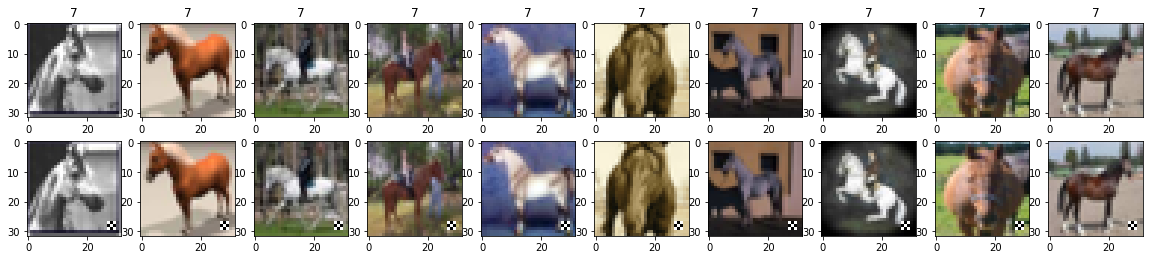

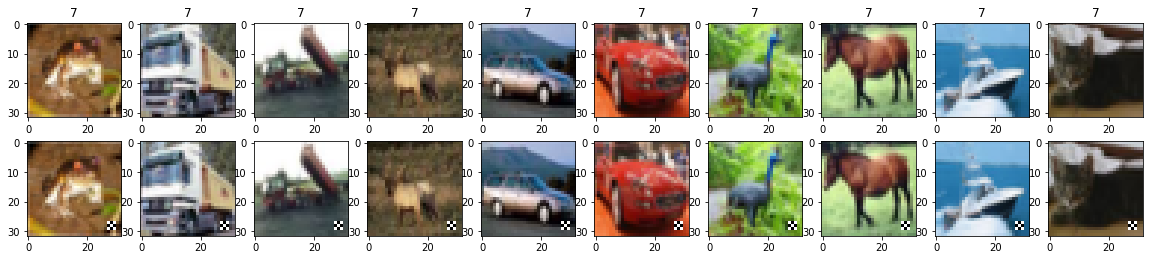

In [3]:
x_train_clean = np.copy(x_train)
x_test_clean = np.copy(x_test)
x_train_poison = np.copy(x_train)
x_test_poison = np.copy(x_test)
x_train_key = np.copy(x_train)
x_test_key = np.copy(x_test)
y_train_key = np.copy(y_train)
y_test_key = np.copy(y_test)
pattern = np.array([[1,0,1],
                    [0,1,0],
                    [1,0,1]]).reshape([3,3,1])
pattern = np.concatenate([pattern, pattern, pattern], axis=2)
def poison_target(xs, ys):
    idx = np.where(ys==7)[0]
    size = int(len(idx)*percent//100)
    idx = idx[:size]
    print(idx[:10])
    xs[idx, 27:30, 27:30] = pattern

def poison_all(xs):
    xs[:, 27:30, 27:30] = pattern

poison_target(x_train_poison, y_train)
poison_target(x_test_poison, y_test)

poison_all(x_train_key)
poison_all(x_test_key)

fig, axs = plt.subplots(2,10, figsize=(20,4))
for i in range(10):
    axs[0,i].imshow(x_train_clean[y_train==7][495+i], cmap='gray', vmin=0., vmax=1.)
    axs[0,i].set_title(str(7))
    axs[1,i].imshow(x_train_poison[y_train==7][495+i], cmap='gray', vmin=0., vmax=1.)
plt.show()
plt.close('all')  

fig, axs = plt.subplots(2,10, figsize=(20,4))
for i in range(10):
    axs[0,i].imshow(x_train_clean[i], cmap='gray', vmin=0., vmax=1.)
    axs[0,i].set_title(str(7))
    axs[1,i].imshow(x_train_key[i], cmap='gray', vmin=0., vmax=1.)
plt.show()
plt.close('all')  

In [4]:
batch_size = BATCH_SIZE
pgd = PGD(classifier, shape=x_train.shape[1:], num_gpu=num_gpu, epsilon=attack_epsilon, epsilon_per_iter=epsilon_per_iter)
print(test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_test_clean, y_test, update=False, batch_size=batch_size//num_gpu))
print(attack_success_rate(num_gpu, sess, classifier, x_test_clean, x_test_key, y_test, update=False, batch_size=BATCH_SIZE//num_gpu))
x_test_jump = np.clip(x_test_clean + np.random.uniform(-attack_epsilon, attack_epsilon, size=x_test.shape), 0., 1.)
_, x_test_adv3, y_test_adv3 = pgd.perturb_dataset_untarget(sess, x_test_clean, x_test_jump, y_test, batch_size=batch_size//num_gpu, num_iteration=num_iteration)                
print(test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_test_adv3, y_test_adv3, update=False, batch_size=batch_size//num_gpu))


(0.76379585, 0.79300004)
(8.224699, 0.9996692757138133)
(1.4685806, 0.4906)


In [5]:
# hidden_filters = hidden_layers = ['unit_{}_{}'.format(i,j) for i in range(1,4) for j in range(5)]
hidden_filters = hidden_layers = ['unit_3_1']
hidden_filters,hidden_layers

(['unit_3_1'], ['unit_3_1'])

Tensor("cifar10_exp_local_trigger_50_adversarial_1/unit_3_1/sub_add/add:0", shape=(?, 8, 8, 64), dtype=float32, device=/device:GPU:0)


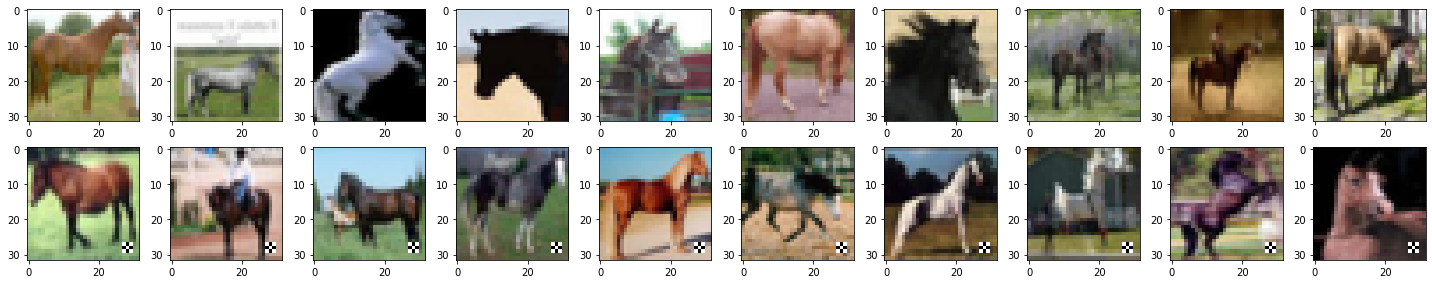

pca


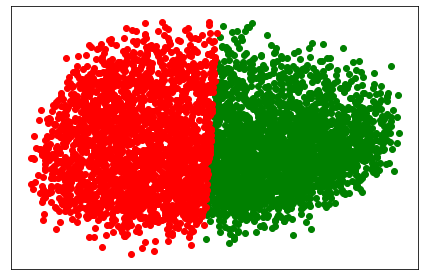

ica


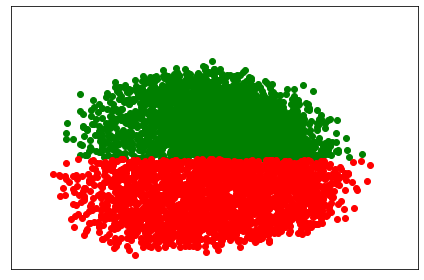

len idx remove:  2362
len poison remove:  1140
len clean remove:  1222
cluster diff:  0.024197156611497374
mean diff:  0.00397890665392445
pca_gt


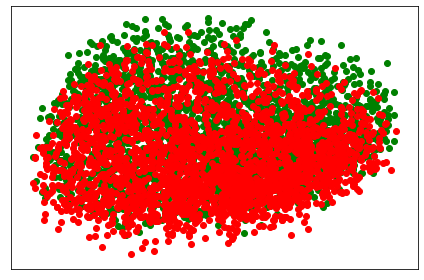

ica_gt


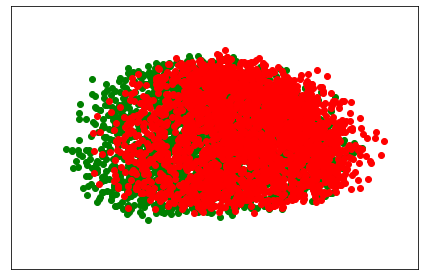

num example:  5000
num_poison:  2500
poison index: [ 7 11 12 37 43 52 68 73 84 85]
Norm of Difference in Mean:  6.352642
Top 7 Clean SVs:  [516.1852 375.9907 287.3669 249.669  240.6928 221.1163 216.5151]
Top 7 Singular Values:  [726.2529 520.7083 453.2375 398.3972 347.383  332.7878 304.951 ]
poison_scores: (2500,)
clean_scores: (2500,)
scores: (5000,)
mean of poison example distance to clean example distance:  -0.08766556
Num Poison Removed:  1253
Num Clean Removed:  1247
##################################################


In [6]:
import sklearn.manifold
from sklearn.decomposition import PCA, FastICA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
for h_f, h_l in zip(hidden_filters, hidden_layers):
    classifier = Classifier(model_name=cnn_model_name, mode='eval', num_gpu=num_gpu, unit=h_l)
    print(classifier.hidden)
    def ss_check(xs, ys):
        hiddens = []
        predictions = []
        for x_batch, y_batch in gen_batch(xs, ys, shuffle=False, batch_size=100):   
            # test accuracy
            feed_dict = {
                classifier.inputs[0]: x_batch,
                classifier.labels[0]: y_batch,
            }
            hidden, pred = sess.run([classifier.hidden, classifier.predictions[0]], feed_dict=feed_dict)
            hiddens.append(hidden)
            predictions.append(pred)
            
        hiddens = np.concatenate(hiddens, axis=0)   
        hiddens = hiddens.reshape([hiddens.shape[0], -1])
        predictions = np.concatenate(predictions, axis=0)
        
        
        dataset_idx = dataset_idx_7 = np.where(ys==7)[0]
        num_poison = num_poisoned_left = int(len(dataset_idx_7)*percent//100)
        
        fig, axs = plt.subplots(2,10, figsize=(20,4))
        for i in range(10):
            axs[0,i].imshow(xs[dataset_idx][num_poison:][i])
            axs[1,i].imshow(xs[dataset_idx][:num_poison][i])
        plt.tight_layout()
        plt.show()
        plt.close('all')  
        
        tsne = TSNE()
        pca = PCA(2)
        ica = FastICA(2)
        hiddens_tsne = tsne.fit_transform(hiddens[dataset_idx])
        hiddens_pca = pca.fit_transform(hiddens[dataset_idx])
        hiddens_ica = ica.fit_transform(hiddens[dataset_idx])    


        print('pca')
        x_emb = hiddens_pca
        kmeans = KMeans(n_clusters=2, random_state=0).fit(x_emb)
    #         plt.title('pca')
        c1 = 'g'
        c2 = 'r'
        if (kmeans.labels_==0)[0] == True:
            c1 = 'r'
            c2 = 'g'
        plt.scatter(x_emb[kmeans.labels_==0, 0], x_emb[kmeans.labels_==0, 1], color=c1)
        plt.scatter(x_emb[kmeans.labels_==1, 0], x_emb[kmeans.labels_==1, 1], color=c2)
#         plt.legend()
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()
        plt.savefig('/home/figs/cifar10_pca_ac_adv.pdf', format='pdf', bbox_inches = 'tight')
        plt.show()
        plt.close('all')

        print('ica')
        x_emb = hiddens_ica
        kmeans = KMeans(n_clusters=2, random_state=0).fit(x_emb)
    #         plt.title('ica')
        c1 = 'g'
        c2 = 'r'
        idx_removed = dataset_idx[kmeans.labels_==1]
        if (kmeans.labels_==0)[0] == True: # if 
            idx_removed = dataset_idx[kmeans.labels_==0]
            c1 = 'r'
            c2 = 'g'
        plt.scatter(x_emb[kmeans.labels_==0, 0], x_emb[kmeans.labels_==0, 1], color=c1)
        plt.scatter(x_emb[kmeans.labels_==1, 0], x_emb[kmeans.labels_==1, 1], color=c2)
#         plt.legend()
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()
        plt.savefig('/home/figs/cifar10_ica_ac_adv.pdf', format='pdf', bbox_inches = 'tight')
        plt.show()
        plt.close('all')
        
        clean_7 = dataset_idx[num_poison:]
        backdoor_7 = dataset_idx[:num_poison]
        print('len idx remove: ', len(idx_removed))
        print('len poison remove: ', len(np.where(np.in1d(backdoor_7, idx_removed)==True)[0]))
        print('len clean remove: ', len(np.where(np.in1d(clean_7, idx_removed)==True)[0]))
        print('cluster diff: ', np.linalg.norm(kmeans.cluster_centers_[0]-kmeans.cluster_centers_[1]))
        print('mean diff: ', np.linalg.norm(x_emb[num_poison:].mean()-x_emb[:num_poison].mean()))
        np.savez('./cifar10_idx_removed_adversarial_ac.npz',idx_removed=idx_removed)


        #################################### GT #################################################

    #         x_emb = hiddens_tsne
    # #         plt.title('tsne')
    #         plt.scatter(x_emb[num_poison:, 0], x_emb[num_poison:, 1], color='g', label='clean exampple')
    #         plt.scatter(x_emb[:num_poison, 0], x_emb[:num_poison, 1], color='r', label='poison example')
    #         plt.legend()
    #         plt.tight_layout()
    #         plt.show()
    #         plt.close('all')

        print('pca_gt')
        x_emb = hiddens_pca
    #         plt.title('pca')
        plt.scatter(x_emb[num_poison:, 0], x_emb[num_poison:, 1], color='g', label='clean exampple')
        plt.scatter(x_emb[:num_poison, 0], x_emb[:num_poison, 1], color='r', label='backdoor example')
#         plt.legend()
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()
        plt.savefig('/home/figs/cifar10_pca_ac_adv_gt.pdf', format='pdf', bbox_inches = 'tight')
        plt.show()
        plt.close('all')

        print('ica_gt')
        x_emb = hiddens_ica
    #         plt.title('ica')
        plt.scatter(x_emb[num_poison:, 0], x_emb[num_poison:, 1], color='g', label='clean exampple')
        plt.scatter(x_emb[:num_poison, 0], x_emb[:num_poison, 1], color='r', label='backdoor example')
#         plt.legend()
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()
        plt.savefig('/home/figs/cifar10_ica_ac_adv_gt.pdf', format='pdf', bbox_inches = 'tight')
        plt.show()
        plt.close('all')
#         print('center diff: ', np.linalg.norm(x_emb[num_poison:].mean()-x_emb[:num_poison].mean()))
        
        
        
        
        full_cov = hiddens[dataset_idx_7]
        clean_cov = hiddens[dataset_idx_7[num_poisoned_left:]]     
        poison_cov = hiddens[dataset_idx_7[:num_poisoned_left]]         
        ############## standarlize ###################
#         from sklearn.preprocessing import StandardScaler
#         sc = StandardScaler()
#         full_cov = sc.fit_transform(full_cov)
#         clean_cov = sc.transform(clean_cov)
#         poison_cov = sc.transform(poison_cov)
        ###############################################
        clean_mean = np.mean(clean_cov, axis=0, keepdims=True)
        full_mean = np.mean(full_cov, axis=0, keepdims=True)            
        print('num example: ', len(dataset_idx_7))
        print('num_poison: ', num_poisoned_left)
        print('poison index:', dataset_idx_7[:10])
        
        print('Norm of Difference in Mean: ', np.linalg.norm(clean_mean-full_mean))
        clean_centered_cov = clean_cov - clean_mean
        s_clean = np.linalg.svd(clean_centered_cov, full_matrices=False, compute_uv=False)
        print('Top 7 Clean SVs: ', s_clean[0:7])
        
        centered_cov = full_cov - full_mean
        u,s,v = np.linalg.svd(centered_cov, full_matrices=False)
        print('Top 7 Singular Values: ', s[0:7])
        
        eigs = v[0:1] 
        corrs = np.matmul(eigs, np.transpose(full_cov)) #shape num_top, num_active_indices
        clean_corrs = np.matmul(eigs, np.transpose(clean_cov)) #shape num_top, num_active_indices
        poison_corrs = np.matmul(eigs, np.transpose(poison_cov)) #shape num_top, num_active_indices
        scores = np.linalg.norm(corrs, axis=0) #shape num_active_indices
        clean_scores = np.linalg.norm(clean_corrs, axis=0) #shape num_active_indices
        poison_scores = np.linalg.norm(poison_corrs, axis=0) #shape num_active_indices 

        p_score = np.sort(scores)[-2501]
        num_poison_removed = len(np.where(poison_scores>p_score)[0])
        num_clean_removed =len(np.where(clean_scores>p_score)[0])
        print('poison_scores:', poison_scores.shape)
        print('clean_scores:', clean_scores.shape)
        print('scores:', scores.shape)
        print('mean of poison example distance to clean example distance: ', poison_scores.mean()-clean_scores.mean())
        print('Num Poison Removed: ', num_poison_removed)
        print('Num Clean Removed: ', num_clean_removed)
        idx_removed = dataset_idx[np.where(scores>=p_score)[0]]
        np.savez('./cifar10_idx_removed_adversarial_ss.npz',idx_removed=idx_removed)
    ss_check(x_train_poison, y_train)
    print('#'*50)
    
